#### Implémentation d'un réseau de neurones (version utilisant autograd, torch.nn et torch.optim)

PyTorch fournit les couches standards des réseaux de neurones sous la forme de modules, permettant de
simplifier et rendre plus lisible l’écriture de l’architecture du réseau.

In [1]:
import torch
import matplotlib.pyplot as plt
plt.ion()
import torch
import numpy as np
import scipy.io
import torch.optim as optim

- Implémenter la fonction ``init_model(nx, nh, ny)`` qui va déclarer l’architecture du model et la
loss et les retourner.

- Le package ``torch.optim`` contient de nombreux optimiseurs courants (différentes variantes de l’algorithme de SGD simple que nous utilisons ici). On modifie ``init_model`` en y ajoutant le _learning rate_ en paramètre d’entrée, et faire en sorte qu’il retourne également l’optimiseur voulu.

In [2]:
def init_model(nx, nh, ny, eta):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        torch.nn.Softmax(dim=1)
    )
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    return model, loss_fn, optimizer

# def init_model(nx, nh, ny):
#     model = torch.nn.Sequential(
#     torch.nn.Linear(nx, nh),
#     torch.nn.Tanh(),
#     torch.nn.Linear(nh, ny),
#     torch.nn.Softmax(dim=1)
#     )
#     loss = torch.nn.CrossEntropyLoss()
#     return model, loss

In [3]:
def loss_accuracy(loss_function, Y_hat, Y):
    loss = loss_function(Y_hat, torch.argmax(Y, dim=1))
    _, predicted_labels = torch.max(Y_hat, 1)
    _, true_labels = torch.max(Y, 1)
    correct_predictions = (predicted_labels == true_labels).float().sum().item()
    total_samples = Y.size(0)
    accuracy = correct_predictions / total_samples

    return loss, accuracy

La fonction sgd prend désormais le modèle en entrée. Pour faire une descente de gradient, on itère
sur ses paramètres et on applique notre descente de gradient.

In [4]:
def sgd(model, eta):
    for param in model.parameters():
        if param.grad is not None:
            with torch.no_grad():
                param -= eta * param.grad
            param.grad.zero_()
    return model

In [5]:
class CirclesData:

    def __init__(self):
        # Grid
        x1,x2 = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
        self._Xgrid = np.array([x1.flatten(), x2.flatten()]).T.astype('float32')

        circles = scipy.io.loadmat("../resources/data/circles.mat")
        self._Xtrain, self._Xtest, self._Ytrain, self._Ytest = circles["Xtrain"].astype('float32'), circles["Xtest"].astype('float32'), circles["Ytrain"].astype('float32'), circles["Ytest"].astype('float32')

        self._Xgrid_th = torch.from_numpy(self._Xgrid)
        self._Xtrain_th = torch.from_numpy(self._Xtrain)
        self._Xtest_th = torch.from_numpy(self._Xtest)
        self._Ytrain_th = torch.from_numpy(self._Ytrain)
        self._Ytest_th = torch.from_numpy(self._Ytest)

        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []

    def __getattr__(self, key):
        if key == "Xgrid": return self._Xgrid_th
        if key == "Xtrain": return self._Xtrain_th
        if key == "Xtest": return self._Xtest_th
        if key == "Ytrain": return self._Ytrain_th
        if key == "Ytest": return self._Ytest_th
        return None

    def plot_data(self):
        plt.figure(1, figsize=(5,5))
        plt.plot(self._Xtrain[self._Ytrain[:,0] == 1,0], self._Xtrain[self._Ytrain[:,0] == 1,1], 'bo', label="Train")
        plt.plot(self._Xtrain[self._Ytrain[:,1] == 1,0], self._Xtrain[self._Ytrain[:,1] == 1,1], 'ro')
        plt.plot(self._Xtest[self._Ytest[:,0] == 1,0], self._Xtest[self._Ytest[:,0] == 1,1], 'b+', label="Test")
        plt.plot(self._Xtest[self._Ytest[:,1] == 1,0], self._Xtest[self._Ytest[:,1] == 1,1], 'r+')
        plt.legend()
        plt.show()

    def plot_data_with_grid(self, Ygrid, title=""):
        plt.figure(2)
        Ygrid = Ygrid[:,1].numpy()
        plt.clf()
        plt.imshow(np.reshape(Ygrid, (40,40)))
        plt.plot(self._Xtrain[self._Ytrain[:,0] == 1,0]*10+20, self._Xtrain[self._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Training")
        plt.plot(self._Xtrain[self._Ytrain[:,1] == 1,0]*10+20, self._Xtrain[self._Ytrain[:,1] == 1,1]*10+20, 'ro')
        plt.plot(self._Xtest[self._Ytest[:,0] == 1,0]*10+20, self._Xtest[self._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
        plt.plot(self._Xtest[self._Ytest[:,1] == 1,0]*10+20, self._Xtest[self._Ytest[:,1] == 1,1]*10+20, 'r+')
        plt.xlim(0,39)
        plt.ylim(0,39)
        plt.clim(0.3,0.7)
        plt.title(title)
        plt.draw()
        plt.pause(1e-3)

    def plot_loss(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
    
        plt.figure(3)
        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(np.array(self.acc_train), label="Training Accuracy")
        plt.plot(np.array(self.acc_test), label="Test Accuracy")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(np.array(self.loss_train), label="Training Loss")
        plt.plot(np.array(self.loss_test), label="Test Loss")
        plt.legend()
        plt.show()

- Remplacer l’appel à la fonction ``forward`` par un appel au modèle, et le calcul de la loss dans
``loss_accuracy`` par un appel à la fonction de loss (nouveau paramètre d’entrée de la fonction
``loss_accuracy`` ). Quand on avait ``Yhat, outs = forward(params, X)``, on aura ``Yhat = model(X)``. Dans ``loss_accuracy``, on a : ``L = loss(Yhat, Y)``

- Si on veut utiliser le module `optim`, on peut remplacer la fonction ``sgd`` par un appel à ``optim.zero_grad()`` avant de faire le ``backward``. Faire un appel à ``optim.step()`` après le backward.

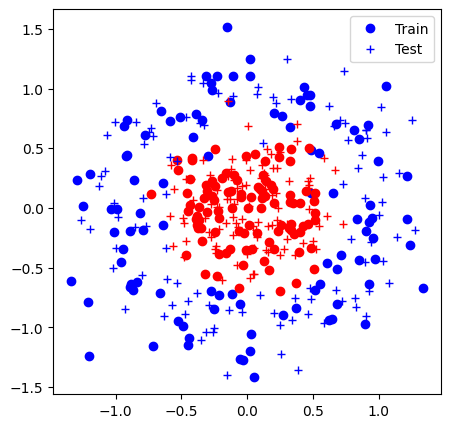

C:\Users\ROG ZEPHYRUS\AppData\Local\Temp\ipykernel_27780\2533346798.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(Xtrain[indsBatch, :], dtype=torch.float32)
C:\Users\ROG ZEPHYRUS\AppData\Local\Temp\ipykernel_27780\2533346798.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Ytrain[indsBatch, :], dtype=torch.float32)


Iter 0: Acc train 0.5% (0.70), acc test 0.5% (0.70)


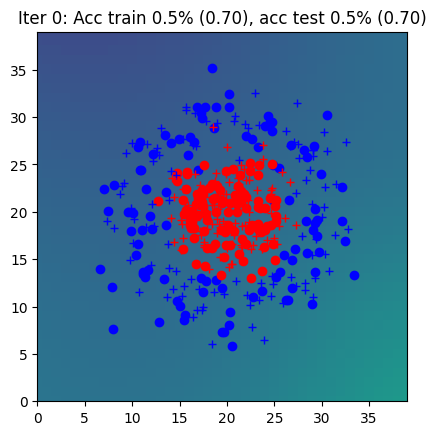

Iter 1: Acc train 0.5% (0.70), acc test 0.5% (0.70)
Iter 2: Acc train 0.5% (0.69), acc test 0.5% (0.69)
Iter 3: Acc train 0.4% (0.69), acc test 0.4% (0.69)
Iter 4: Acc train 0.4% (0.69), acc test 0.5% (0.69)
Iter 5: Acc train 0.5% (0.69), acc test 0.5% (0.69)
Iter 6: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 7: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 8: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 9: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 10: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 11: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 12: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 13: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 14: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 15: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 16: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 17: Acc train 0.6% (0.68), acc test 0.6% (0.69)
Iter 18: Acc train 0.6% (0.68), acc test 0.6% (0.69)
Iter 19: Acc train 0.6% (0.68), acc test 0.6% (0.69)
It

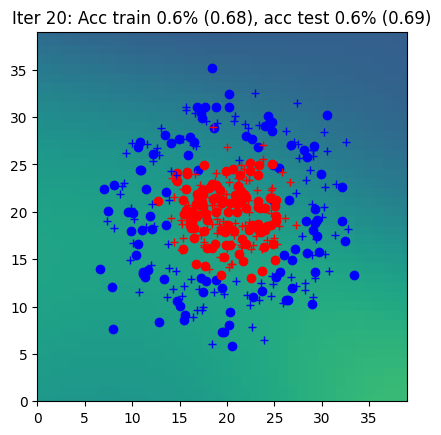

Iter 21: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 22: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 23: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 24: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 25: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 26: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 27: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 28: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 29: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 30: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 31: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 32: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 33: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 34: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 35: Acc train 0.6% (0.67), acc test 0.6% (0.68)
Iter 36: Acc train 0.6% (0.67), acc test 0.6% (0.68)
Iter 37: Acc train 0.6% (0.67), acc test 0.6% (0.68)
Iter 38: Acc train 0.6% (0.67), acc test 0.6% (0.67)
Iter 39: Acc train 0.7% (0.67), acc test 0.6% 

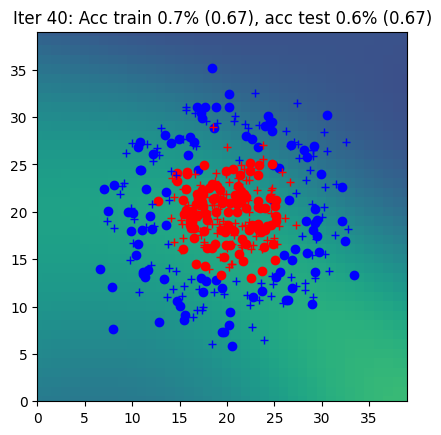

Iter 41: Acc train 0.7% (0.67), acc test 0.6% (0.67)
Iter 42: Acc train 0.6% (0.67), acc test 0.6% (0.67)
Iter 43: Acc train 0.6% (0.67), acc test 0.6% (0.67)
Iter 44: Acc train 0.7% (0.67), acc test 0.6% (0.67)
Iter 45: Acc train 0.6% (0.66), acc test 0.6% (0.67)
Iter 46: Acc train 0.6% (0.66), acc test 0.6% (0.67)
Iter 47: Acc train 0.6% (0.66), acc test 0.6% (0.67)
Iter 48: Acc train 0.7% (0.66), acc test 0.6% (0.66)
Iter 49: Acc train 0.7% (0.66), acc test 0.6% (0.66)
Iter 50: Acc train 0.7% (0.66), acc test 0.7% (0.66)
Iter 51: Acc train 0.7% (0.66), acc test 0.7% (0.66)
Iter 52: Acc train 0.7% (0.66), acc test 0.7% (0.66)
Iter 53: Acc train 0.7% (0.65), acc test 0.7% (0.66)
Iter 54: Acc train 0.7% (0.65), acc test 0.7% (0.66)
Iter 55: Acc train 0.7% (0.65), acc test 0.7% (0.66)
Iter 56: Acc train 0.7% (0.65), acc test 0.7% (0.65)
Iter 57: Acc train 0.7% (0.65), acc test 0.7% (0.65)
Iter 58: Acc train 0.7% (0.65), acc test 0.7% (0.65)
Iter 59: Acc train 0.7% (0.64), acc test 0.7% 

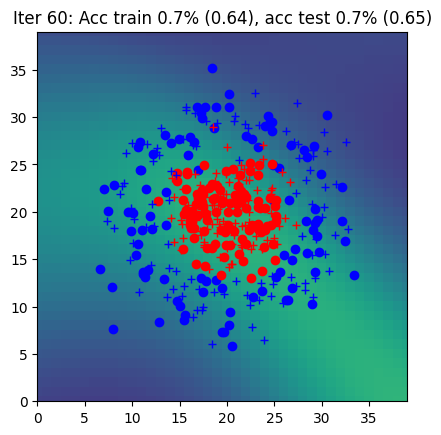

Iter 61: Acc train 0.7% (0.64), acc test 0.7% (0.65)
Iter 62: Acc train 0.7% (0.64), acc test 0.7% (0.64)
Iter 63: Acc train 0.7% (0.64), acc test 0.7% (0.64)
Iter 64: Acc train 0.7% (0.63), acc test 0.7% (0.64)
Iter 65: Acc train 0.7% (0.63), acc test 0.7% (0.64)
Iter 66: Acc train 0.7% (0.63), acc test 0.7% (0.64)
Iter 67: Acc train 0.7% (0.63), acc test 0.7% (0.63)
Iter 68: Acc train 0.7% (0.63), acc test 0.8% (0.63)
Iter 69: Acc train 0.8% (0.62), acc test 0.8% (0.63)
Iter 70: Acc train 0.8% (0.62), acc test 0.7% (0.63)
Iter 71: Acc train 0.8% (0.62), acc test 0.7% (0.63)
Iter 72: Acc train 0.8% (0.62), acc test 0.8% (0.62)
Iter 73: Acc train 0.8% (0.61), acc test 0.7% (0.62)
Iter 74: Acc train 0.8% (0.61), acc test 0.8% (0.62)
Iter 75: Acc train 0.8% (0.61), acc test 0.8% (0.62)
Iter 76: Acc train 0.8% (0.61), acc test 0.8% (0.61)
Iter 77: Acc train 0.8% (0.60), acc test 0.8% (0.61)
Iter 78: Acc train 0.8% (0.60), acc test 0.8% (0.61)
Iter 79: Acc train 0.8% (0.60), acc test 0.8% 

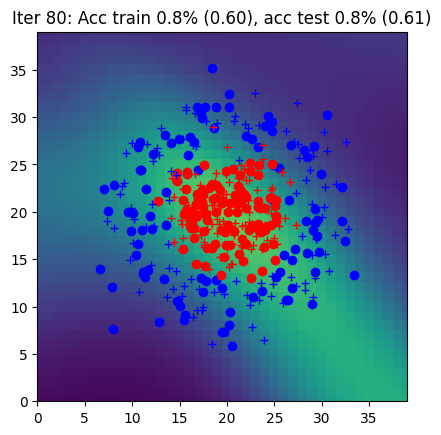

Iter 81: Acc train 0.8% (0.59), acc test 0.8% (0.60)
Iter 82: Acc train 0.8% (0.59), acc test 0.8% (0.60)
Iter 83: Acc train 0.8% (0.59), acc test 0.8% (0.60)
Iter 84: Acc train 0.8% (0.59), acc test 0.8% (0.60)
Iter 85: Acc train 0.8% (0.58), acc test 0.8% (0.59)
Iter 86: Acc train 0.8% (0.58), acc test 0.8% (0.59)
Iter 87: Acc train 0.8% (0.58), acc test 0.8% (0.59)
Iter 88: Acc train 0.8% (0.58), acc test 0.8% (0.59)
Iter 89: Acc train 0.8% (0.57), acc test 0.8% (0.58)
Iter 90: Acc train 0.8% (0.57), acc test 0.8% (0.58)
Iter 91: Acc train 0.8% (0.57), acc test 0.8% (0.58)
Iter 92: Acc train 0.8% (0.56), acc test 0.8% (0.58)
Iter 93: Acc train 0.8% (0.56), acc test 0.8% (0.57)
Iter 94: Acc train 0.8% (0.56), acc test 0.8% (0.57)
Iter 95: Acc train 0.9% (0.56), acc test 0.8% (0.57)
Iter 96: Acc train 0.9% (0.55), acc test 0.8% (0.57)
Iter 97: Acc train 0.9% (0.55), acc test 0.8% (0.56)
Iter 98: Acc train 0.9% (0.55), acc test 0.8% (0.56)
Iter 99: Acc train 0.9% (0.55), acc test 0.8% 

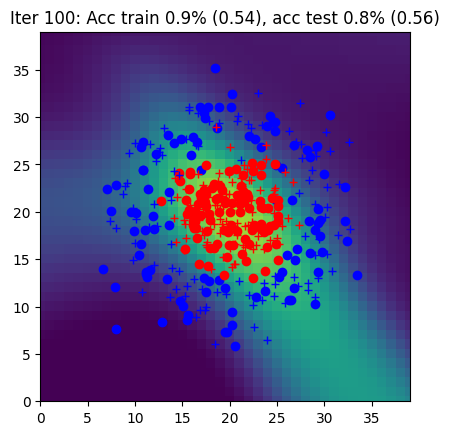

Iter 101: Acc train 0.9% (0.54), acc test 0.8% (0.55)
Iter 102: Acc train 0.9% (0.54), acc test 0.8% (0.55)
Iter 103: Acc train 0.9% (0.54), acc test 0.8% (0.55)
Iter 104: Acc train 0.9% (0.53), acc test 0.8% (0.55)
Iter 105: Acc train 0.9% (0.53), acc test 0.8% (0.55)
Iter 106: Acc train 0.9% (0.53), acc test 0.8% (0.54)
Iter 107: Acc train 0.9% (0.53), acc test 0.8% (0.54)
Iter 108: Acc train 0.9% (0.53), acc test 0.8% (0.54)
Iter 109: Acc train 0.9% (0.52), acc test 0.9% (0.54)
Iter 110: Acc train 0.9% (0.52), acc test 0.8% (0.53)
Iter 111: Acc train 0.9% (0.52), acc test 0.9% (0.53)
Iter 112: Acc train 0.9% (0.52), acc test 0.9% (0.53)
Iter 113: Acc train 0.9% (0.51), acc test 0.9% (0.53)
Iter 114: Acc train 0.9% (0.51), acc test 0.9% (0.52)
Iter 115: Acc train 0.9% (0.51), acc test 0.9% (0.52)
Iter 116: Acc train 0.9% (0.51), acc test 0.9% (0.52)
Iter 117: Acc train 0.9% (0.51), acc test 0.9% (0.52)
Iter 118: Acc train 0.9% (0.50), acc test 0.9% (0.52)
Iter 119: Acc train 0.9% (0.

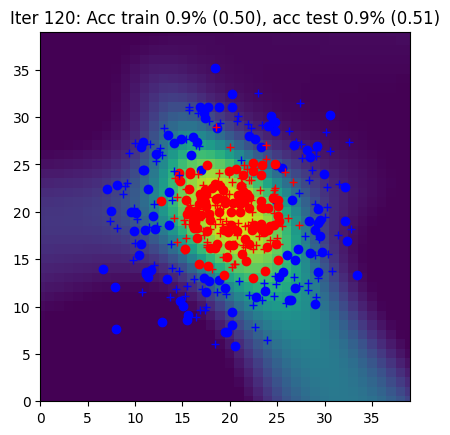

Iter 121: Acc train 0.9% (0.50), acc test 0.9% (0.51)
Iter 122: Acc train 0.9% (0.49), acc test 0.9% (0.51)
Iter 123: Acc train 0.9% (0.49), acc test 0.9% (0.50)
Iter 124: Acc train 0.9% (0.49), acc test 0.9% (0.50)
Iter 125: Acc train 0.9% (0.49), acc test 0.9% (0.50)
Iter 126: Acc train 0.9% (0.49), acc test 0.9% (0.50)
Iter 127: Acc train 0.9% (0.49), acc test 0.9% (0.50)
Iter 128: Acc train 0.9% (0.48), acc test 0.9% (0.49)
Iter 129: Acc train 0.9% (0.48), acc test 0.9% (0.49)
Iter 130: Acc train 0.9% (0.48), acc test 0.9% (0.49)
Iter 131: Acc train 0.9% (0.48), acc test 0.9% (0.49)
Iter 132: Acc train 0.9% (0.48), acc test 0.9% (0.49)
Iter 133: Acc train 0.9% (0.47), acc test 0.9% (0.49)
Iter 134: Acc train 0.9% (0.47), acc test 0.9% (0.48)
Iter 135: Acc train 0.9% (0.47), acc test 0.9% (0.48)
Iter 136: Acc train 0.9% (0.47), acc test 0.9% (0.48)
Iter 137: Acc train 0.9% (0.47), acc test 0.9% (0.48)
Iter 138: Acc train 0.9% (0.47), acc test 0.9% (0.48)
Iter 139: Acc train 0.9% (0.

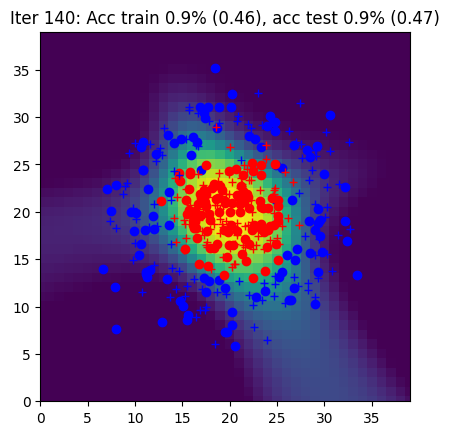

Iter 141: Acc train 0.9% (0.46), acc test 0.9% (0.47)
Iter 142: Acc train 0.9% (0.46), acc test 0.9% (0.47)
Iter 143: Acc train 0.9% (0.46), acc test 0.9% (0.47)
Iter 144: Acc train 0.9% (0.46), acc test 0.9% (0.47)
Iter 145: Acc train 0.9% (0.46), acc test 0.9% (0.47)
Iter 146: Acc train 0.9% (0.45), acc test 0.9% (0.46)
Iter 147: Acc train 0.9% (0.45), acc test 0.9% (0.46)
Iter 148: Acc train 1.0% (0.45), acc test 0.9% (0.46)
Iter 149: Acc train 1.0% (0.45), acc test 0.9% (0.46)


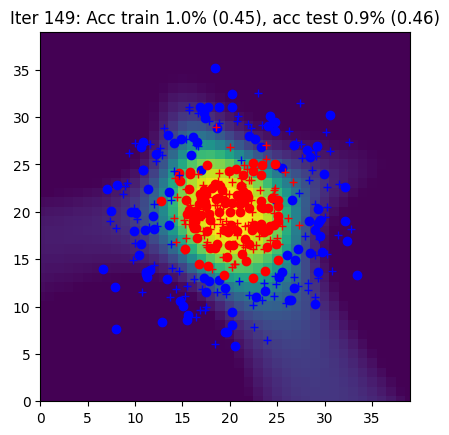

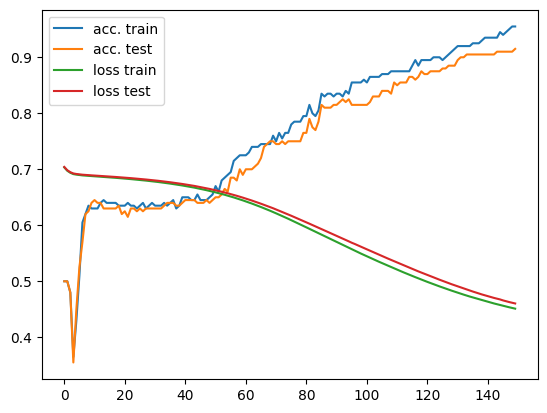

In [6]:
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.05
iter = 150

# model, loss_fn = init_model(nx, nh, ny)
model, loss_fn, optimizer = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

for iteration in range(iter):
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)

        X = torch.tensor(Xtrain[indsBatch, :], dtype=torch.float32)
        Y = torch.tensor(Ytrain[indsBatch, :], dtype=torch.float32)

        optimizer.zero_grad()   # à désactiver si vous travaillez avec init_model(nx, nh, ny)
        
        y_hat = model(X)
        loss, accuracy = loss_accuracy(loss_fn, y_hat, Y)
        loss.backward()
        
        # sgd(model, eta)
        optimizer.step()    # à désactiver si vous travaillez avec init_model(nx, nh, ny)

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss_fn, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss_fn, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    if iteration % 20 == 0 or iteration == iter - 1:
        data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot([tensor.detach().numpy() for tensor in curves[2]], label="loss train")
plt.plot([tensor.detach().numpy() for tensor in curves[3]], label="loss test")
plt.legend()
plt.show()